In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.cm as cm
from matplotlib import cm

pd.set_option('display.max_rows', 60)

In [86]:
# setting values

path = "../Datasets/train - new file - 20230303 135859685.csv"
dataset_path = "../Datasets/train - mix agent.csv"
n_targets = 8

In [87]:
# reading from the file dropping nan values
names = ['timestamp', 
        'id', 
        'x', 'y', 'z', 
        'head orientation', 
        'body orientation', 
        'true target', 
        'probability 0',
        'probability 1',
        'probability 2',
        'probability 3',
        'probability 4',
        'probability 5',
        'probability 6',
        'probability 7',
        ]
df = pd.read_csv(path, header=None, names=names)
df.dropna(inplace=True)

data = pd.read_csv(dataset_path, header=None, names=names)

## Analyze dataset

In [88]:
data
n_trials = len(data[['timestamp', 'id']].drop_duplicates())
print("The number of trials are: ", n_trials)

trials_targets = data[['timestamp', 'id', 'true target']].drop_duplicates()
trials_targets = trials_targets.groupby(['true target'])['id'].count()
print("The number of trials for each target:")
print(trials_targets.to_frame())

The number of trials are:  616
The number of trials for each target:
             id
true target    
0            93
1            64
2            61
3            63
4            88
5            69
6            88
7            90


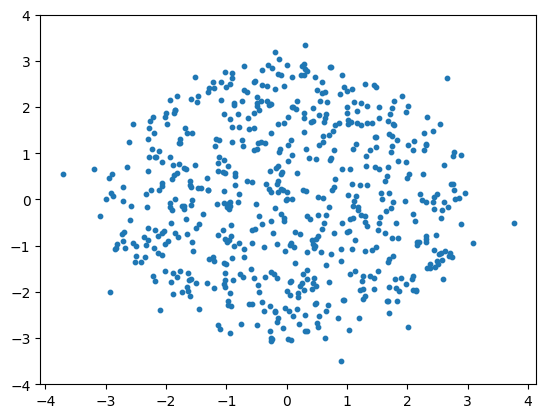

In [90]:
initial_positions = data.groupby(["timestamp", "id"], as_index=False).first()
initial_positions
plt.scatter(initial_positions['x'], initial_positions['z'], s=10)
plt.ylim(-4, 4)
plt.show()

## Analyze results

In [91]:
# adding the predicted target as a new column
def pred(x):
    pred = x[-n_targets:].copy().astype(float).reset_index(drop=True).idxmax()
    return pred
    
df["prediction target"] = df.apply(lambda x: pred(x), axis=1)
df["similarity"] = df.apply(lambda x: 1 if x["true target"] == x["prediction target"] else 0, axis=1)

In [92]:
n_trials = len(df[['timestamp', 'id']].drop_duplicates())
print("The number of trials are: ", n_trials)

trials_targets = df[['timestamp', 'id', 'true target']].drop_duplicates()
trials_targets = trials_targets.groupby(['true target'])['id'].count()
print("The number of trials for each target:")
print(trials_targets.to_frame())

The number of trials are:  108
The number of trials for each target:
             id
true target    
0            18
1            17
2            10
3            16
4            12
5             9
6            11
7            15


In [93]:
timestamp = df[['timestamp']].drop_duplicates()

columns=["timestamp", 
         "trial points", 
         "accuracy", 
         "target", 
         "predicted targets", 
         "#predicted targets",
         "#predicted targets/length %"]

accu = pd.DataFrame(columns=columns)

for index, t in timestamp.iterrows():
    trial = df[df["timestamp"] == t["timestamp"]]
    accuracy = trial["similarity"].sum() / len(trial)
    target = trial["true target"].unique() 
    predicted_targets = trial["prediction target"].unique()

    match = trial[trial["true target"] == trial["prediction target"]]
    first_match_index = match.index[0] + 1 if not match.empty else trial.index[-1] + 1
    wrong = first_match_index - trial.index[0]

    row = {"timestamp": [t["timestamp"]], 
           "trial points": [len(trial)], 
           "accuracy": [accuracy],
           "target": target,
           "predicted targets" : [predicted_targets],
           "#predicted targets" : [len(predicted_targets)],
           "#predicted targets/length %" : [len(predicted_targets) / len(trial) * 100],
           "wrong prediction time till correct": wrong,
           "wrong prediction time till correct/length": wrong / len(trial)
           }

    accu = pd.concat([accu, pd.DataFrame(row)], ignore_index=True)    

accu[["trial points", "target", "#predicted targets"]] = accu[["trial points", "target", "#predicted targets"]].astype(str).astype(int)
accu.head()


,timestamp,trial points,accuracy,target,predicted targets,#predicted targets,#predicted targets/length %,wrong prediction time till correct,wrong prediction time till correct/length
0,3/3/2023 1:59:14 PM,167,0.311377,7,"[2, 3, 5, 6, 7, 0, 1]",7,4.191617,36.0,0.215569
1,3/3/2023 1:59:19 PM,82,0.158537,5,"[7, 0, 5]",3,3.658537,68.0,0.829268
2,3/3/2023 1:59:22 PM,76,0.236842,4,"[3, 4, 2]",3,3.947368,55.0,0.723684
3,3/3/2023 1:59:29 PM,131,0.549618,6,"[3, 6, 7]",3,2.290076,40.0,0.305344
4,3/3/2023 1:59:36 PM,138,0.847826,1,"[2, 3, 1]",3,2.173913,22.0,0.159420


### Number of predicted targets in relation to trial length 

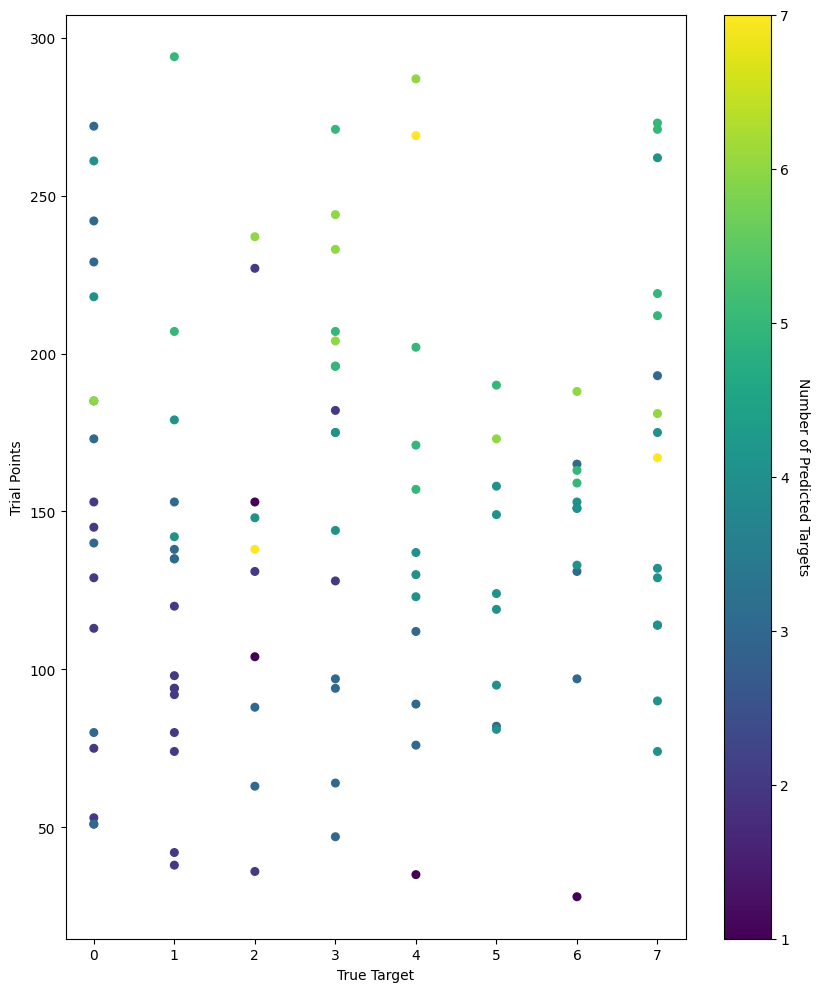

In [97]:
fig = plt.figure(figsize=(10,12))

plt.scatter(accu["target"], accu["trial points"], c = accu["#predicted targets"], s=30)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Number of Predicted Targets', rotation=270, labelpad=15)

plt.xlabel("True Target")
plt.ylabel("Trial Points")
plt.savefig("../Plots/Number of predicted targets in relation to trial length")
plt.show()


In [ ]:
# df = accu.copy()

# width = depth = -0.1

# xpos = df["target"] - width/2  # x coordinates of each bar
# ypos = df["trial points"] - depth/2  # y coordinates of each bar
# zpos = 0 
# dz = df["#predicted targets"]

# cs = ["bisque", 
#         "darkorange", 
#         "peachpuff", 
#         "gold", 
#         "oldlace", 
#         "khaki", 
#         "darkkhaki",
#         "olive"] * len(xpos)

# df["colors"] = df.apply(lambda x: cs[int(x["target"])], axis=1) 

# colors = cm.tab20(np.linspace(0.5, 0.9, len(xpos)))
# colors = df["colors"]

# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(111, projection='3d')
# ax.bar3d(xpos-width, ypos+1.5*depth, zpos, width, depth*3, dz, shade=False, edgecolor = 'black', color=colors, alpha=0.7)

# ax.set_xlabel("True Target")
# ax.set_ylabel("Trial Points")
# ax.set_zlabel("Number of Predicted Targets")
# plt.savefig("../Plots/Number of predicted targets in relation to trial length")
# plt.show()

### Most frequent predicted targets for each target

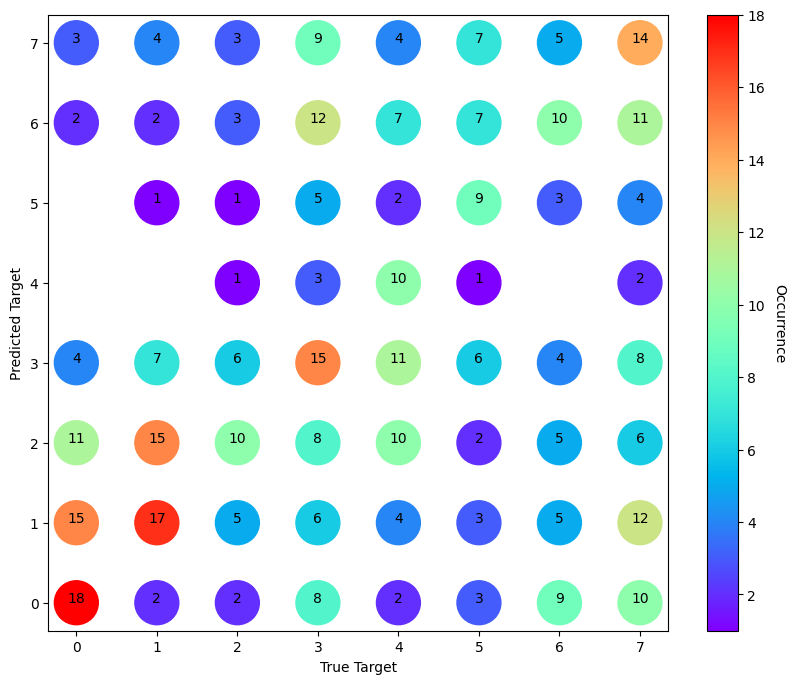

In [98]:
df1 = accu[["timestamp", "trial points", "accuracy", "target", "predicted targets"]].explode("predicted targets")
df1 = df1.groupby(["target", "predicted targets"], as_index=False)["timestamp"].count() 

fig = plt.figure(figsize=(10,8))
plt.scatter(df1["target"], df1["predicted targets"], c = df1["timestamp"], cmap='rainbow', s=1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Occurrence", rotation=270, labelpad=15)

for i, txt in enumerate(df1["timestamp"]):
    plt.annotate(txt, (df1["target"][i], df1["predicted targets"][i]), ha='center')

plt.ylabel
plt.xlabel("True Target")
plt.ylabel("Predicted Target")
plt.savefig("../Plots/Most frequent predicted targets for each target")
plt.show()

In [ ]:
# # most frequent predicted targets for each target
 
# df = accu[["timestamp", "trial points", "accuracy", "target", "predicted targets"]].explode("predicted targets")
# df = df.groupby(["target", "predicted targets"], as_index=False)["timestamp"].count()

# cs = ["bisque", 
#         "darkorange", 
#         "peachpuff", 
#         "gold", 
#         "oldlace", 
#         "khaki", 
#         "darkkhaki",
#         "olive"] * len(xpos)
# df["colors"] = df.apply(lambda x: cs[int(x["target"])], axis=1) 

# width = depth = -0.1

# xpos = df["target"] - width/2  # x coordinates of each bar
# ypos = df["predicted targets"] - depth/2  # y coordinates of each bar
# zpos = 0 
# dz = df["timestamp"]

# colors = df["colors"]

# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(111, projection='3d')
# ax.bar3d(xpos-width, ypos+1.5*depth, zpos, width, depth, dz, shade=False, edgecolor = 'black', color=colors, alpha=0.7)

# ax.set_xlabel('True Target')
# ax.set_ylabel('Predicted Target')
# ax.set_zlabel('Occurrence')
# plt.savefig("../Plots/Most frequent predicted targets for each target")
# plt.show()

### 

In [99]:
res = accu.groupby(["target", "#predicted targets"], as_index=False)["timestamp"].count()

res1 = accu.groupby(["target", "#predicted targets"], as_index=False).mean()

# cs = ["bisque", 
#         "darkorange", 
#         "peachpuff", 
#         "gold", 
#         "oldlace", 
#         "khaki", 
#         "darkkhaki",
#         "olive"] * len(xpos)
# res1["colors"] = res1.apply(lambda x: cs[int(x["target"])], axis=1) 
res1

res = pd.merge(res, res1, on = ["target", "#predicted targets"])
# res

C:\Users\shokoofehv\AppData\Local\Temp\ipykernel_8628\660952951.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res1 = accu.groupby(["target", "#predicted targets"], as_index=False).mean()


### Number of predicted targets for each target 

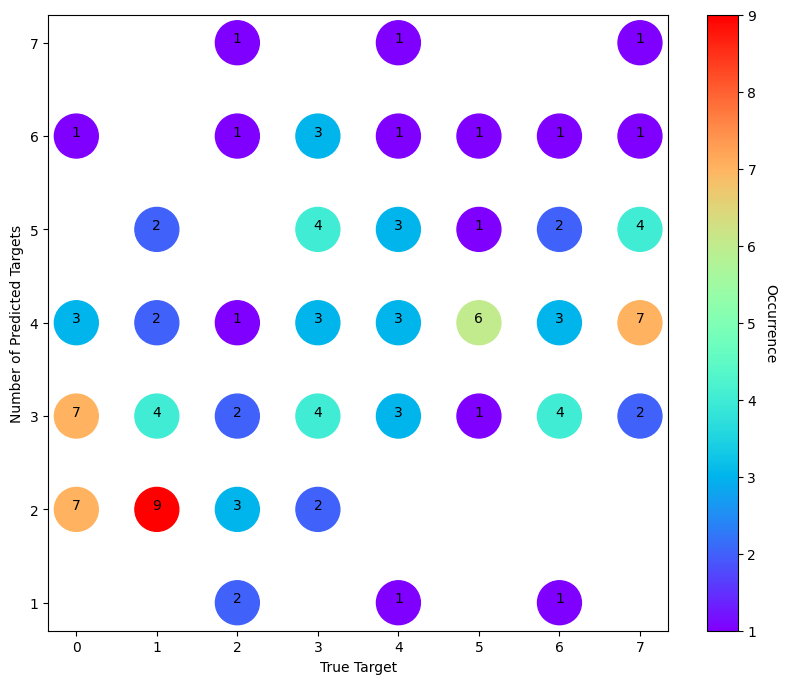

In [100]:
fig = plt.figure(figsize=(10,8))
plt.scatter(res["target"], res["#predicted targets"], c = res["timestamp"], cmap='rainbow', s=1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Occurrence", rotation=270, labelpad=15)

for i, txt in enumerate(res["timestamp"]):
    plt.annotate(txt, (res["target"][i], res["#predicted targets"][i]), ha='center')

plt.ylabel
plt.xlabel("True Target")
plt.ylabel("Number of Predicted Targets")
plt.savefig("../Plots/Number of predicted targets for each target")
plt.show()

In [ ]:
# # number of wrong predictions 

# width = depth = -0.1

# xpos = res["target"] - width/2  # x coordinates of each bar
# ypos = res["#predicted targets"] - depth/2  # y coordinates of each bar
# zpos = 0 # z coordinates of each bar
# dz = res["timestamp"]

# colors = cm.tab20(np.linspace(0.5, 0.9, len(xpos)))
# colors = res["colors"]
# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(111, projection='3d')
# ax.bar3d(xpos-width, ypos+1.5*depth, zpos, width, depth, dz, shade=False, edgecolor = 'black', color=colors, alpha=0.7)

# ax.set_xlabel('True Target')
# ax.set_ylabel('Number of Predicted Targets')
# ax.set_zlabel('Occurrence')
# plt.savefig("../Plots/Number of predicted targets for each target")
# plt.show()

### Avg Accuracy for each number of predicted targets and true targets

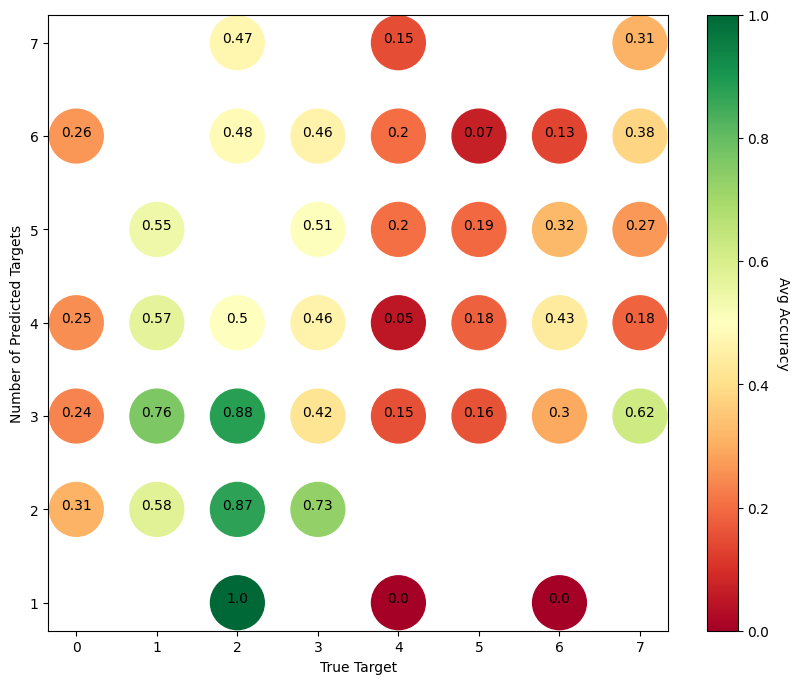

In [104]:
fig = plt.figure(figsize=(10,8))
plt.scatter(res["target"], res["#predicted targets"], c = res["accuracy"], cmap='RdYlGn', s=1500)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Avg Accuracy", rotation=270, labelpad=15)

for i, txt in enumerate(res["accuracy"]):
    plt.annotate(round(txt, 2), (res["target"][i], res["#predicted targets"][i]), ha='center')

plt.ylabel
plt.xlabel("True Target")
plt.ylabel("Number of Predicted Targets")
plt.savefig("../Plots/Avg Accuracy for each number of predicted targets and true targets")
plt.show()

In [ ]:
# width = depth = -0.1

# xpos = res["target"] - width/2  # x coordinates of each bar
# ypos = res["#predicted targets"] - depth/2  # y coordinates of each bar
# zpos = 0 # z coordinates of each bar

# dz = res["accuracy"]

# # cs = ['r', 'g', 'b', 'y', 'c', 'k', 'grey'] * len(xpos)
# colors = cm.tab20(np.linspace(0.5, 0.9, len(xpos)))
# colors = res["colors"]
# fig = plt.figure(figsize=(20,20))
# ax = fig.add_subplot(111, projection='3d')
# ax.bar3d(xpos-width, ypos+1.5*depth, zpos, width, depth, dz, shade=False, edgecolor = 'black', color=colors)


# ax.set_xlabel('True Target')
# ax.set_ylabel('Number of Predicted Targets')
# ax.set_zlabel('Avg Accuracy')
# plt.savefig("../Plots/Avg Accuracy for each number of predicted targets and tru targets")
# plt.show()

### Wrong prediction ratio

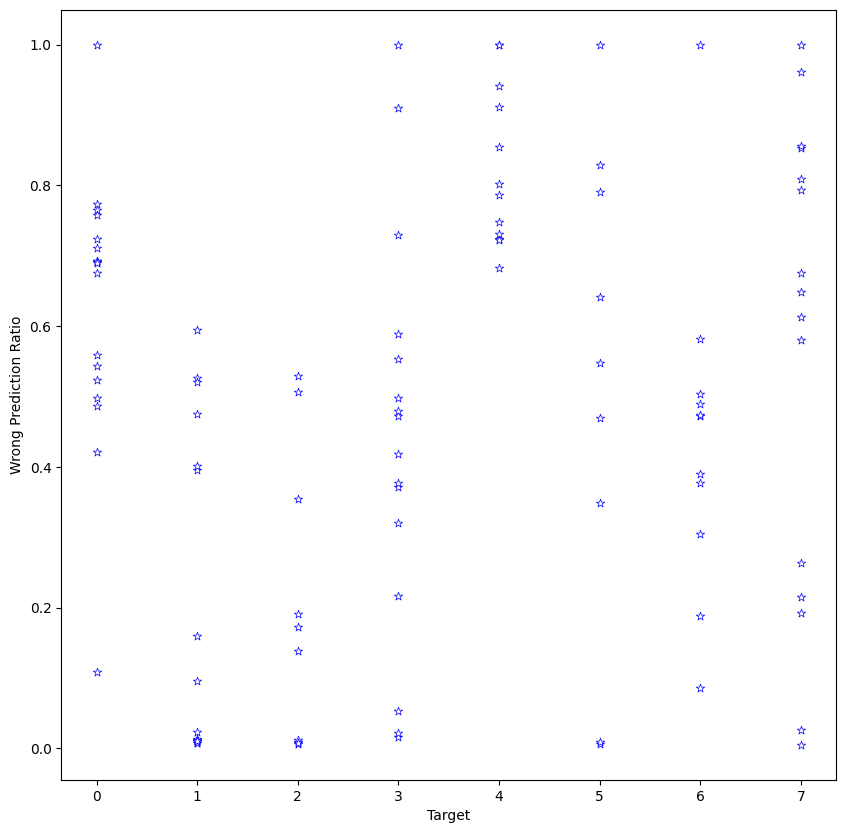

In [102]:
fig = plt.figure(figsize=(10,10))
plt.scatter(accu["target"], accu["wrong prediction time till correct/length"],
            s=40, linewidths=.5, edgecolors='b', marker='*', c='w')
plt.xlabel("Target")
plt.ylabel("Wrong Prediction Ratio")
plt.savefig("../Plots/Wrong prediction ratio")
plt.show()

### Wrong prediction ratio and accuracy

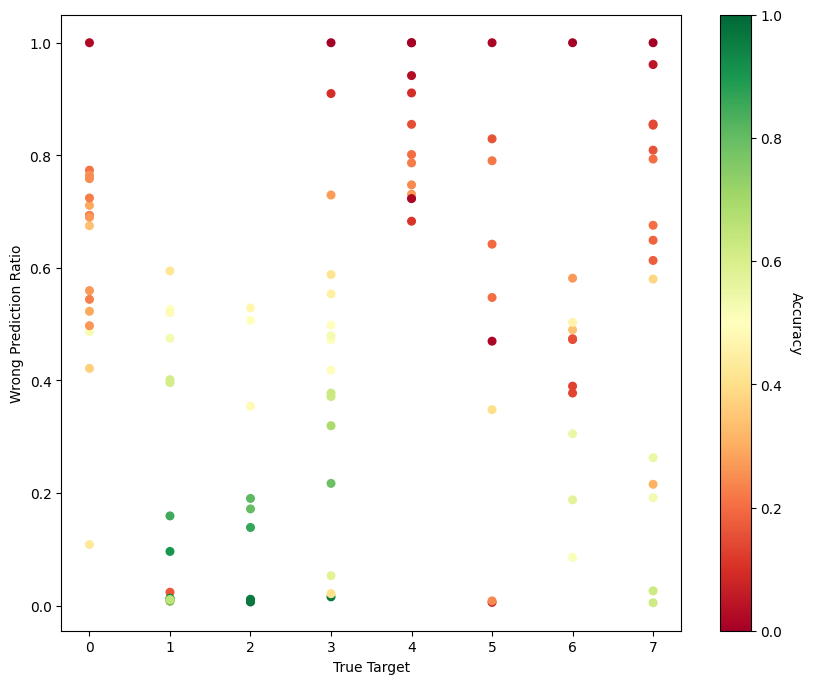

In [103]:
fig = plt.figure(figsize=(10,8))
plt.scatter(accu["target"], accu["wrong prediction time till correct/length"], c = accu["accuracy"], cmap='RdYlGn', s=30)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Accuracy", rotation=270, labelpad=15)

# for i, txt in enumerate(accu["accuracy"]):
#     plt.annotate(round(txt, 2), (accu["target"][i], accu["wrong prediction time till correct/length"][i]), ha='center')

plt.ylabel
plt.xlabel("True Target")
plt.ylabel("Wrong Prediction Ratio")
plt.savefig("../Plots/Wrong prediction ratio with accuracy")
plt.show()

In [ ]:
# df = accu.copy()

# width = depth = -0.1

# xpos = df["target"] #- width/2  # x coordinates of each bar
# ypos = df["wrong prediction time till correct/length"] #- depth/2  # y coordinates of each bar
# zpos = 0 
# dz = df["accuracy"]

# df["colors"] = df.apply(lambda x: cs[int(x["target"])], axis=1) 

# colors = cm.tab20(np.linspace(0.5, 0.9, len(xpos)))
# colors = df["colors"]

# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(111, projection='3d')
# ax.bar3d(xpos-width, ypos+depth/10, zpos, width, depth/10, dz, shade=False, edgecolor = 'black', color=colors, alpha=0.7)

# ax.set_xlabel("True Target")
# ax.set_ylabel("Wrong Prediction Ratio")
# ax.set_zlabel("Accuracy")
# plt.savefig("../Plots/Wrong prediction ratio with accuracy")
# plt.show()